**1) Загрузка и осмотр первичных данных**  
**EDA**

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

orders = pd.read_csv('data_orders.csv')

а) Оценка общей структуры данных  
Осмотр дата сета orders    

In [66]:
print(f"Shape: {orders.shape}\n")
print("Data Types:\n", orders.dtypes.to_string(), "\n")
print("Null Values:\n", orders.isnull().sum().to_string())

Shape: (10716, 8)

Data Types:
 order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64 

Null Values:
 order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409


б) Оценка пропущенных значений


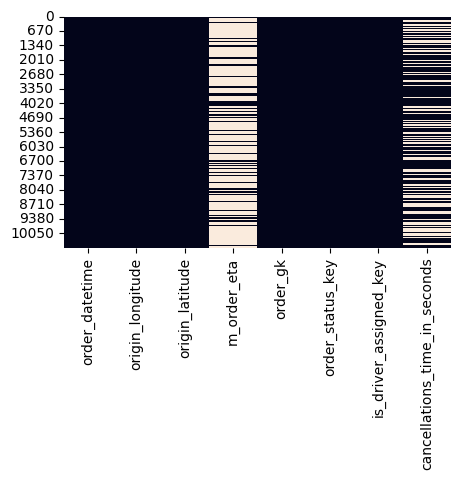

In [67]:
plt.figure(figsize=(5, 3))
sns.heatmap(orders.isnull(), 
            cbar=False) 
plt.show()

в) Анализ распределения переменных

In [68]:
desc = orders.describe(include='all')

# Добавляем количество уникальных значений для каждого столбца
unique_counts = orders.nunique().to_frame('unique').T
desc = pd.concat([desc, unique_counts])
desc

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
count,10716,10716.000000,10716.000000,2814.000000,1.071600e+04,10716.000000,10716.000000,7307.000000
unique,9921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,23:36:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-0.964323,51.450541,441.415423,3.000598e+12,5.590612,0.262598,157.892021
std,NaN,0.022818,0.011984,288.006379,2.396261e+07,2.328845,0.440066,213.366963
min,NaN,-1.066957,51.399323,60.000000,3.000550e+12,4.000000,0.000000,3.000000
25%,NaN,-0.974363,51.444643,233.000000,3.000583e+12,4.000000,0.000000,45.000000
50%,NaN,-0.966386,51.451972,368.500000,3.000595e+12,4.000000,0.000000,98.000000
75%,NaN,-0.949605,51.456725,653.000000,3.000623e+12,9.000000,1.000000,187.500000


In [69]:
# исследование природы NaN значений по полю m_order_eta
print((orders['is_driver_assigned_key'] == 0).sum())  
print((orders['m_order_eta'].isnull()).sum())

7902
7902


In [70]:
# исследование природы NaN значений по полю order_status_key
print(f'{(orders['order_status_key'] == 9).sum()}')  
print((orders['cancellations_time_in_seconds'].isnull()).sum())

3409
3409


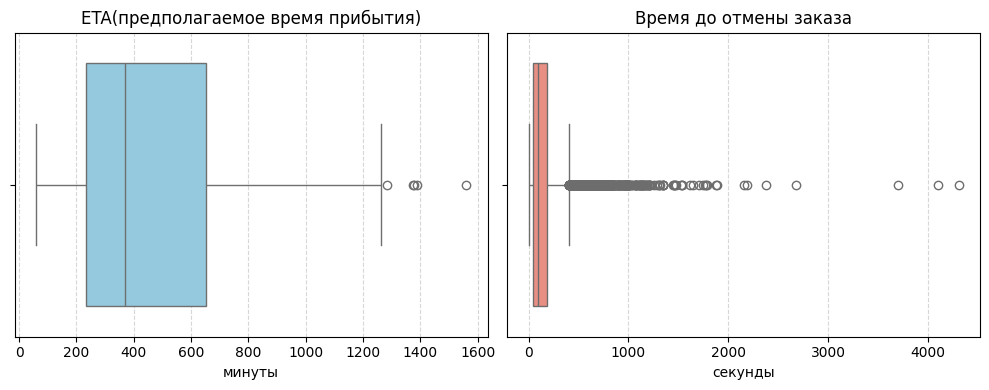

In [71]:
plt.figure(figsize=(10, 4))  # распределение переменных и оценка выбросов по m_order_eta и cancellations_time_in_seconds

plt.subplot(1, 2, 1) 
sns.boxplot(x=orders['m_order_eta'], color='skyblue')
plt.title('ETA(предполагаемое время прибытия)')
plt.xlabel('минуты')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2) 
sns.boxplot(x=orders['cancellations_time_in_seconds'], color='salmon') 
plt.title('Время до отмены заказа')
plt.xlabel('секунды')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout() 
plt.show()

**Выводы из анализа распределения переменных**
- Пропуски в данных:

m_order_eta (NaN):
Встречаются только в заказах без назначенного водителя (is_driver_assigned_key = False).
Обоснование: ETA (время до прибытия) не может быть рассчитано, если водитель не принял заказ.

cancellations_time_in_seconds (NaN):
Наблюдаются только для заказов со статусом order_status_key = 9 (отмена системой).
Обоснование: такие заказы отменяются автоматически, время отмены не фиксируется.

- Выбросы:

m_order_eta:
Присутствуют экстремальные значения.
Решение: заменены на граничные значения.

cancellations_time_in_seconds:
Присутствуют экстремальные значения (до 4303 секунд).
Решение: удаление (по условию задачи).

- Проверка категориальных переменных:

Поля order_status_key и is_driver_assigned_key содержат ровно 2 уникальных значения (бинарные флаги), что соответствует описанию данных.

**2) Преобразование дата фрейма**

In [72]:
orders['failure_reason'] = orders.apply(
    lambda row: 'Отмена до назначения водителя' if (row['order_status_key'] == 4 and row['is_driver_assigned_key'] == 0)
    else 'Отмена после назначения водителя' if (row['order_status_key'] == 4 and row['is_driver_assigned_key'] == 1)
    else 'Отказ системы (без водителя)' if (row['order_status_key'] == 9 and row['is_driver_assigned_key'] == 0)
    else 'Отказ системы (с водителем)',
    axis=1
) # разбивка отказов по категориям

orders['is_driver_assigned_key'] = orders['is_driver_assigned_key'].map({0: 'Водитель не назначен', 1: 'Водитель назначен'})

orders['hour'] = pd.to_datetime(orders['order_datetime'], format='%H:%M:%S').dt.hour # промежуточный столбец для анализа по часам

q1 = orders['m_order_eta'].quantile(0.25) 
q3 = orders['m_order_eta'].quantile(0.75) # замена выбросов по полю m_order_eta методом межквартильного размаха (IQR)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
orders['m_order_eta'] = orders['m_order_eta'].clip(upper=upper_bound)


**3) Распределение заказов по причинам отмен** (Задание 1)

- Постройте распределение заказов по причинам отказа: отмены до и после назначения водителя, а также причины отклонения заказа.

- Проанализируйте график. Какая категория имеет наибольшее количество заказов?

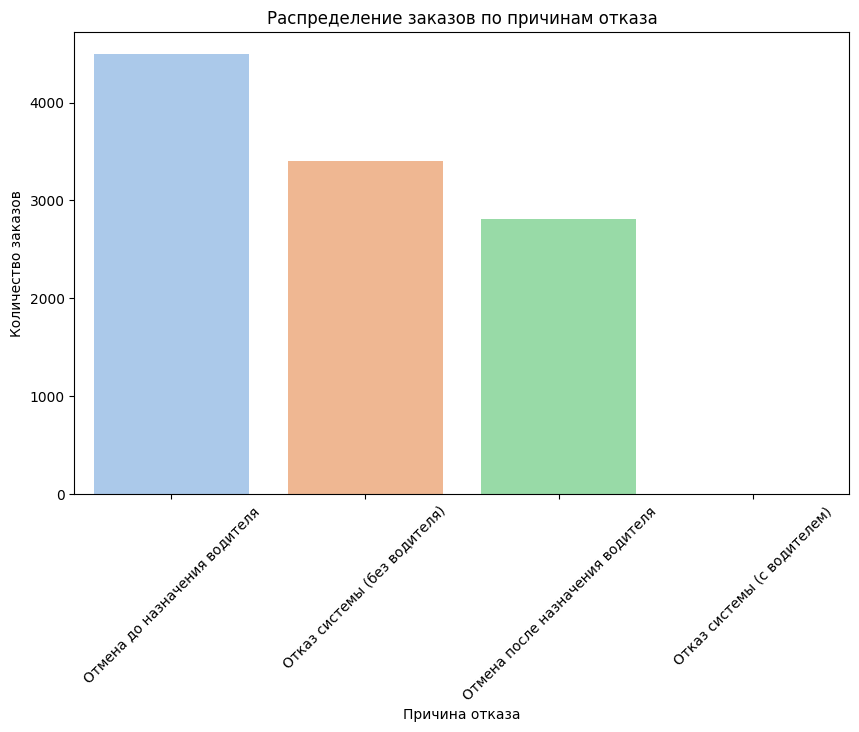

In [73]:
failure_counts = orders['failure_reason'].value_counts() # Считаем количество отказов по категориям

#print(failure_counts)  

plt.figure(figsize=(10, 6))
sns.barplot(x=failure_counts.index, y=failure_counts.values, hue=failure_counts.index, palette='pastel')
plt.title('Распределение заказов по причинам отказа')
plt.xlabel('Причина отказа')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.show()

    Отмена до назначения водителя       4496  
    Отказ системы (без водителя)        3406  
    Отмена после назначения водителя    2811  
    Отказ системы (с водителем)            3  

- Основная причина отмен: "Отмена до назначения водителя" (4496 заказов) — ~42% от всех отказов.

**4) Распределение отмененных заказов по часам** (Задание 2)

- Постройте распределение отмененных заказов по часам.

- Есть ли часы, в которых наблюдается аномально высокое количество отказов по одной из категорий?

- В какие часы происходит больше всего отказов? Как это можно объяснить?

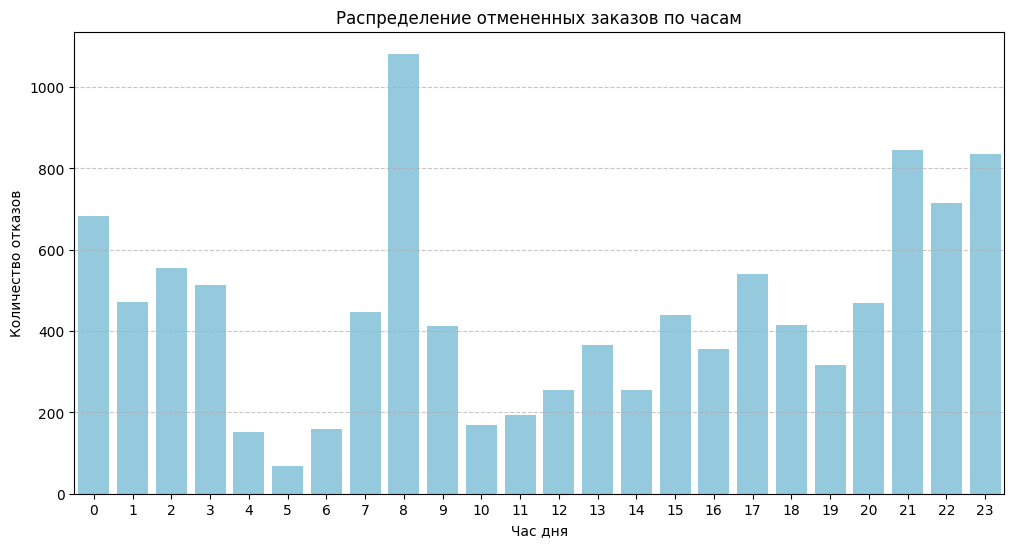

In [74]:
plt.figure(figsize=(12, 6))
sns.countplot(data=orders, x='hour', color='skyblue')
plt.title('Распределение отмененных заказов по часам')
plt.xlabel('Час дня')
plt.ylabel('Количество отказов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

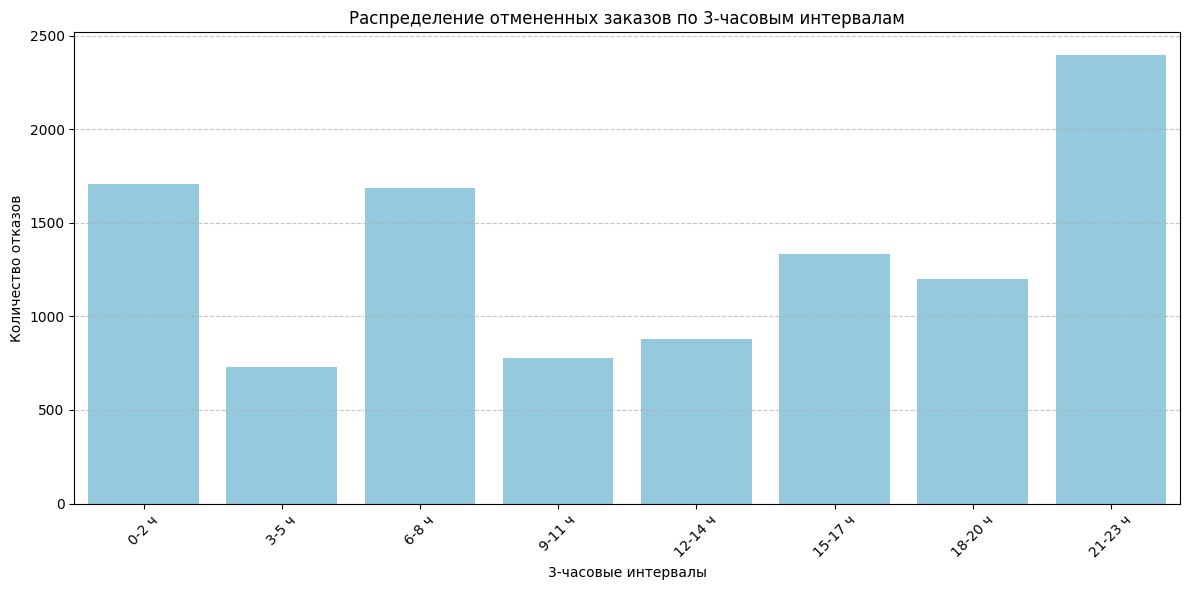

In [75]:
orders['hour_group'] = (orders['hour'] // 3) * 3
orders['hour_group_label'] = orders['hour_group'].astype(str) + '-' + (orders['hour_group']+2).astype(str) + ' ч'

# Создаем правильный порядок сортировки интервалов
hour_order = [f"{h}-{h+2} ч" for h in sorted(orders['hour_group'].unique())]

plt.figure(figsize=(12, 6))
sns.countplot(
    data=orders,
    x='hour_group_label',
    color='skyblue',
    order=hour_order  # Используем заранее подготовленный порядок
)
plt.title('Распределение отмененных заказов по 3-часовым интервалам')
plt.xlabel('3-часовые интервалы')
plt.ylabel('Количество отказов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

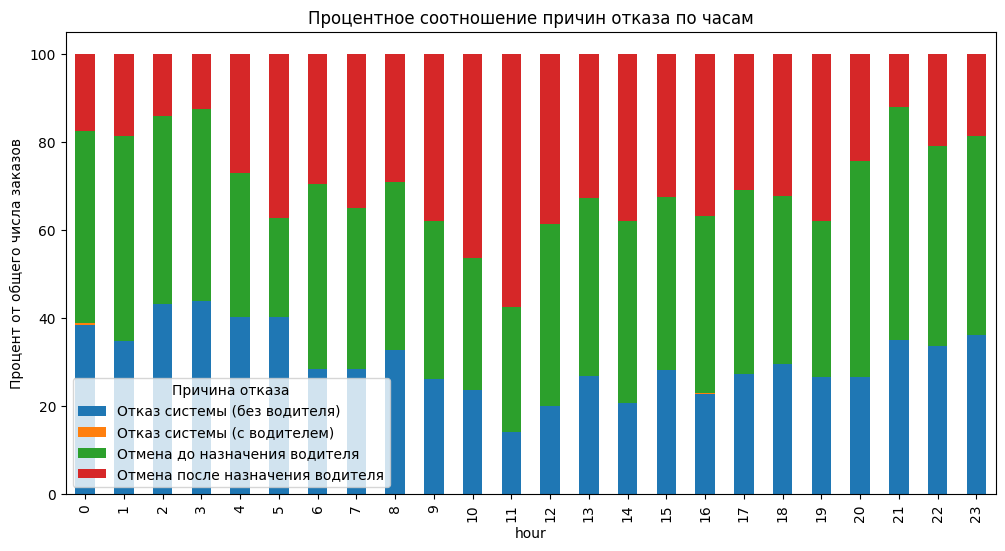

In [76]:
pivot_orders = orders.pivot_table(
    index='hour',          
    columns='failure_reason', 
    values='order_gk',      # подсчет по уникальным номерам заказов
    aggfunc='count',     
    fill_value=0           
)
# Рассчитываем процент от общего числа заказов в каждом часе
pivot_orders = pivot_orders.div(pivot_orders.sum(axis=1), axis=0) * 100
pivot_orders.style.format("{:.2f}%")
pivot_orders.plot(
    kind='bar', 
    stacked=True,
    figsize=(12, 6),
    title='Процентное соотношение причин отказа по часам'
)
plt.ylabel('Процент от общего числа заказов')
plt.legend(title='Причина отказа', loc=3)
plt.show()

**ВЫВОДЫ**
1) Пик отмен в 8:00 может быть связан с двумя основными факторами:

- Высокий спрос в утренние часы, приводящий к увеличению общего числа заказов (и, как следствие, росту абсолютного числа отмен).

- Пробки в час пик, из-за которых водители или пассажиры чаще отменяют поездки (водители — из-за нежелания стоять в traffic, пассажиры — из-за поиска более быстрых альтернатив).

2) Рост отмен с 21:00 до 02:00 объясняется следующими причинами:

- Увеличение числа заказов в ночное время (развлекательные поездки, отсутствие общественного транспорта).

- Нежелание водителей выполнять заказы в отдаленные районы (повышенные риски, длинный обратный путь без пассажиров).

3) Скачок отмен после назначения водителя в 10:00–11:00 вероятно вызван:

- Снижением спроса на такси после окончания утреннего часа пика: пассажиры переключаются на метро, каршеринг или другие варианты, если дорожная ситуация улучшается.

- Возможной задержкой водителей из-за остаточных пробок, что увеличивает время подачи и провоцирует отмены.

**5) Среднее время до отмены заказа (с водителем и без)** (Задание 3)

- Постройте график среднего времени до отмены с водителем и без, по часам.

- Если в данных есть выбросы, лучше их удалить.

- Какие выводы можно сделать из этого графика?

а) очищаем поле cancellations_time_in_seconds от NaN и выбросов

In [77]:
orders_copy = orders.dropna(subset='cancellations_time_in_seconds') # удаляем NaN значения

q1 = orders_copy['cancellations_time_in_seconds'].quantile(0.25) 
q3 = orders_copy['cancellations_time_in_seconds'].quantile(0.75)
iqr = q3 - q1
orders_copy = orders_copy[(orders_copy['cancellations_time_in_seconds'] < q3 + 1.5 * iqr)]

б) группируем данные и строим график

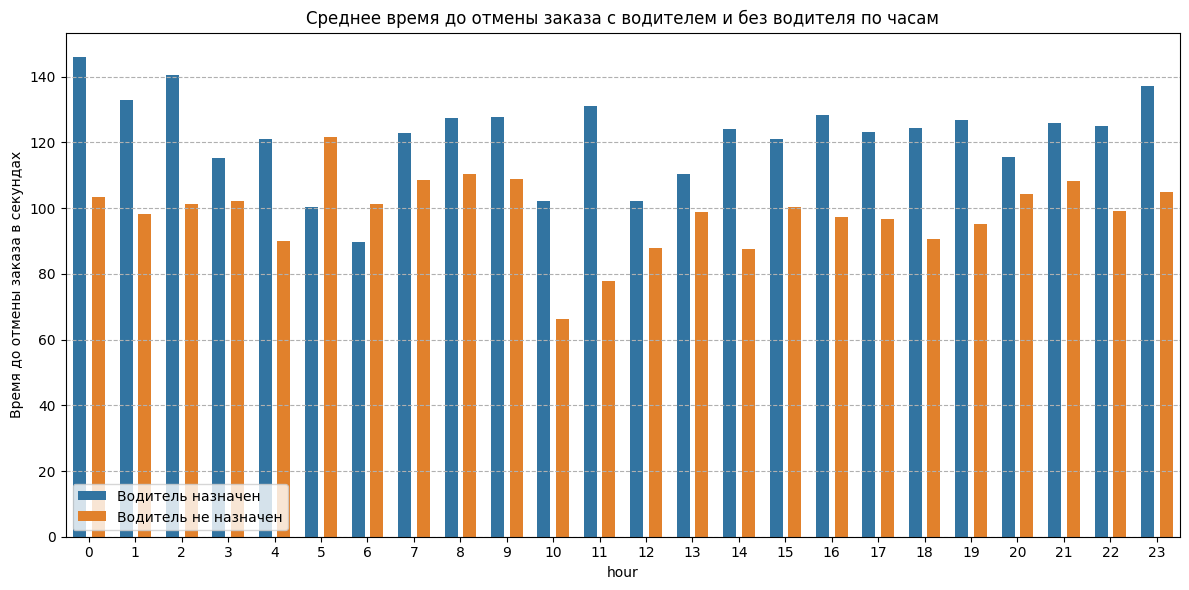

In [78]:
groupped_orders = (
    orders_copy
    .groupby(['hour', 'is_driver_assigned_key'], as_index=False)['cancellations_time_in_seconds']
    .mean()
)

plt.figure(figsize=(12, 6))
sns.barplot(groupped_orders, x="hour", y="cancellations_time_in_seconds", hue="is_driver_assigned_key", gap=0.3)
plt.title('Среднее время до отмены заказа с водителем и без водителя по часам')
plt.grid(axis='y', linestyle='--', alpha=1)
plt.ylabel('Время до отмены заказа в секундах')
plt.legend(title='', loc=3)
plt.tight_layout()
plt.show()

Вывод: среднее время отмены заказы увеличивается, если водитель назначен. Данное условие не выполняется в 2х случаях из 24 (5 и 6 часов утра)

**6) Распределение среднего ETA (предполагаемого времени прибытия) по часам** (Задание 4)

- Постройте график распределения среднего ETA по часам.

- Как можно объяснить этот график?

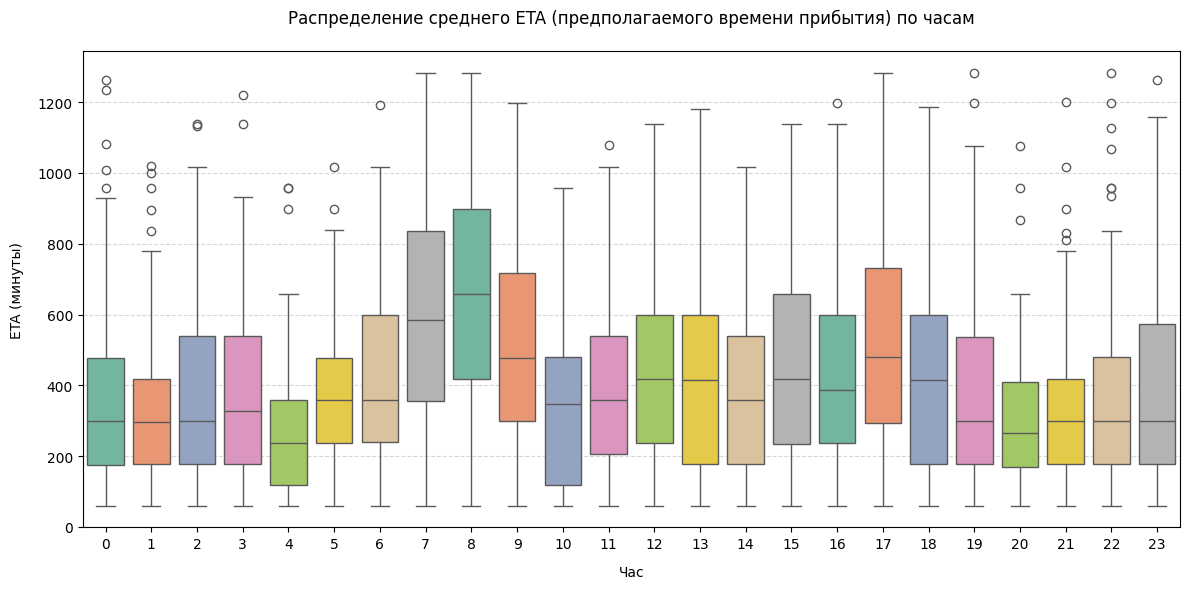

In [79]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=orders,
    x='hour',
    y='m_order_eta',
    hue='hour',  
    palette='Set2',  
    legend=False 
)
plt.title("Распределение среднего ETA (предполагаемого времени прибытия) по часам", pad=20)
plt.xlabel("Час", labelpad=10)
plt.ylabel("ETA (минуты)", labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

ВЫВОД  
- В часы высокой нагрузки (поездки на работу/домой) ETA увеличивается из-за большого количества заказов и пробок.
- В дневное время ETA снижается (умеренный спрос, стабильное количество водителей)
- В ночное время возможны резкие колебания ETA (мало водителей, но и меньше пассажиров)
